# Particle Categorical

In [8]:
import tensorflow as tf

import tensorflow.keras as keras
import tensorflow.keras.backend as K
from tensorflow.keras.layers import Input, Dense, Activation, BatchNormalization
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import Flatten, Reshape, Lambda
from tensorflow.keras.utils import plot_model
from tensorflow.keras import Model

import os
import os.path as osp
import sys
sys.path.append('/home/jcollins')

import numpy as np
#from scipy import linalg as LA

import matplotlib
import matplotlib.pyplot as plt

# %load_ext autoreload
# %autoreload 2

from utils.tf_sinkhorn import sinkhorn_knopp_tf_64, ground_distance_tf_nograd

import pandas
import matplotlib.pyplot as plt

import h5py

In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)

1 Physical GPUs, 1 Logical GPUs


In [3]:
def create_dir(dir_path):
    ''' Creates a directory (or nested directories) if they don't exist.
    '''
    if not osp.exists(dir_path):
        os.makedirs(dir_path)

    return dir_path

output_dir = './data/'

### Define VAE

In [141]:
def plot_latent_space_2(encoder, valid_data, xrange = [0.9,1e6]):
    latent_valid = np.array(encoder.predict(valid_data)[:3])
    perms = np.argsort(np.mean(latent_valid[1],axis=0))
    latent_valid = latent_valid[:,:,perms]
    
    #print(latent_valid.shape)
    plt.figure(figsize=(10,2.5))
    plt.subplot(1,2,1)
    
    
    
    plt.scatter(np.exp(-np.mean(latent_valid[1,:,:],axis=0)/2),np.sqrt(np.mean(np.square(latent_valid[0,:,:]),axis=0)),s=10.)
    plt.semilogx()
    plt.xlim(xrange)
    plt.ylim([0,2.])
    plt.ylabel(r'$\sqrt{<\mu^2>}$')
    plt.xlabel(r'$<\sigma>^{-1}$')
    
    plt.subplot(1,2,2)
    
    bins = np.logspace(np.log10(xrange[0]),np.log10(xrange[1]),50)

    plt.hist(np.sqrt(np.mean(np.square(latent_valid[0,:,:20]),axis=0) + np.exp(latent_valid[1,:,:20]))/np.exp(latent_valid[1,:,:20]/2),
         bins=bins,stacked=True)

    plt.xlabel("Inverse resolution")
    plt.semilogx()
    plt.xlim(xrange)
    plt.ylim([0,5e4])





    plt.show()

def plot_latent_space(encoder, valid_data, xrange = [0.9,1e6]):
    latent_valid = np.array(encoder.predict(valid_data)[:3])
    perms = np.argsort(np.mean(latent_valid[1],axis=0))
    latent_valid = latent_valid[:,:,perms]
    plt.figure(figsize=(18,4))

    plt.subplot(1,3,1)
    plt.hist(latent_valid[0,:,0],bins=np.arange(-5,5.00001,0.1),label="latent dimension 1",alpha=0.75)
    plt.hist(latent_valid[0,:,1],bins=np.arange(-5,5.00001,0.1),label="latent dimension 2",alpha=0.75)
    plt.title("latent means")
    plt.xlim([-5,5])
    plt.legend()
    
    plt.subplot(1,3,2)
    bins = np.logspace(-0.1,4,100)
    plt.hist(np.sqrt(np.mean(np.square(latent_valid[0,:,0])) + np.exp(latent_valid[1,:,0]))/np.exp(latent_valid[1,:,0]/2),label="latent dimension 1",alpha=0.75,bins=bins)
    plt.hist(np.sqrt(np.mean(np.square(latent_valid[0,:,1])) + np.exp(latent_valid[1,:,1]))/np.exp(latent_valid[1,:,1]/2),label="latent dimension 2",alpha=0.75,bins=bins)
    plt.title("Inverse resolution")
    plt.semilogx()
    plt.xlim(xrange)
    plt.legend()



    plt.subplot(1,3,3)
    plt.hist(latent_valid[2,:,0],bins=np.arange(-5,5.00001,0.1),label="latent dimension 1",alpha=0.75)
    plt.hist(latent_valid[2,:,1],bins=np.arange(-5,5.00001,0.1),label="latent dimension 2",alpha=0.75)
    plt.title("sampled z")
    plt.xlim([-5,5])
    plt.legend()

    plt.show()
    
def plot_latent_map(encoder, decoder, train_data_banana,cats,
                    scales = np.array([[-2,2],[-2,2]]),
                    values = np.array([[-1,0,1],[-1,0,1]]),
                    latent_plotrange = [-3,3],
                   linewidth = 2.):
    
    
    cats = np.array(cats)
    scales = np.array(scales)
    values = np.array(values)
    numpoints = 100
    ranges = scales[:,1]-scales[:,0]

    latent_valid_mu, latent_valid_logvar, latent_valid,_,_ = encoder.predict(train_data_banana)
    perms = np.argsort(np.mean(latent_valid_logvar,axis=0))
    
    codes1_proj = np.array([np.vstack([np.ones(numpoints)*value,np.linspace(scales[0,0],scales[0,1],numpoints)]).T for value in values[0]])
    codes2_proj = np.array([np.vstack([np.linspace(scales[1,0],scales[1,1],numpoints),np.ones(numpoints)*value]).T for value in values[1]])

    codes1 = np.zeros((3,numpoints,7))
    codes1[:,:,5:] = cats.reshape(1,1,2)
    codes1[:,:,perms[0]] = codes2_proj[:,:,0]
    codes1[:,:,perms[1]] = codes2_proj[:,:,1]
    codes2 = np.zeros((3,numpoints,7))
    codes2[:,:,5:] = cats.reshape(1,2)
    codes2[:,:,perms[0]] = codes1_proj[:,:,0]
    codes2[:,:,perms[1]] = codes1_proj[:,:,1]
#     if long_axis == 0:
#         codes0 = np.array([[code,short_values[0]] for code in codes])
#         codes1 = np.array([[code,short_values[1]] for code in codes])
#         codes2 = np.array([[code,short_values[2]] for code in codes])
#     else:
#         codes0 = np.array([[short_values[0],code] for code in codes])
#         codes1 = np.array([[short_values[1],code] for code in codes])
#         codes2 = np.array([[short_values[2],code] for code in codes])

    fig, ax = plt.subplots(1,2,figsize=(12,5),gridspec_kw={'width_ratios': [1, 1]})
    

    
    ax[0].scatter(latent_valid[:,perms[0]],latent_valid[:,perms[1]],color='gray',alpha=0.1,s=0.4)
    ax[1].scatter(train_data_banana[:,0],train_data_banana[:,1],color='gray',alpha=0.1,s=0.4)

    cmap = matplotlib.cm.get_cmap('cool')
    
    for i,codes in enumerate(codes1):
#         points = np.zeros((numpoints,2))
        color = cmap(2./3 - i/3.)
        points = decoder.predict([codes[:,:5],codes[:,5:]])
        ax[1].plot(points[:,0],points[:,1],color = color,linewidth=linewidth)
        ax[0].plot(codes[:,perms[0]],codes[:,perms[1]],color = color,linewidth=linewidth)
        
    cmap = matplotlib.cm.get_cmap('autumn')
    
    for i,codes in enumerate(codes2):
        color = cmap(i/3.)
        points = decoder.predict([codes[:,:5],codes[:,5:]])
        ax[1].plot(points[:,0],points[:,1],color = color,linewidth=linewidth)
        ax[0].plot(codes[:,perms[0]],codes[:,perms[1]],color = color,linewidth=linewidth)

#     points = np.zeros((int(long_range/0.01),2))
#     points = decoder.predict(codes1)
#     plt.scatter(points[:,0],points[:,1],label=("latent axis " + str(1-long_axis) + " = " + str(short_values[1])),s=0.5)

#     points = np.zeros((int(long_range/0.01),2))
#     points = decoder.predict(codes2)
# #     plt.scatter(points[:,0],points[:,1],label=("latent axis " + str(1-long_axis) + " = " + str(short_values[2])),s=0.5)
#     plt.plot(points[:,0],points[:,1],label=("latent axis " + str(1-long_axis) + " = " + str(short_values[2])))
    ax[1].set_xlim([-3,3])
    ax[1].set_ylim([-3,3])
    ax[0].set_xlim(latent_plotrange)
    ax[0].set_ylim(latent_plotrange)
    ax[0].set_title('Latent Space')
    ax[1].set_title('Real Space')
    #plt.legend()

    plt.show()

## Generate training data

Input data is 2D, generated in the shape of a banana (plotted below) defined by two gaussians with widths 1 and 0.1. The VAE will be tasked with reconstructing the 2D location of the input points, using euclidean distance as the reconstruction error. The latent space is 2D, so can in principle easily encode everything about the input. This will be regulated by the variational latent space

In [13]:
# path to file
fn =  './data/events_anomalydetection.h5'

In [15]:
# Option 1: Load everything into memory
df = pandas.read_hdf(fn)
print(df.shape)
print("Memory in GB:",sum(df.memory_usage(deep=True)) / (1024**3))

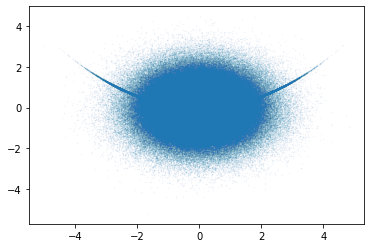

In [7]:
numtrain = 500000
numvalid = 50000

train_data = np.random.normal(scale=(1,1e-3),size=(numtrain,2))
train_data[:,1] = train_data[:,1]+train_data[:,0]*train_data[:,0]/7
valid_data = np.random.normal(scale=(1,1e-3),size=(numvalid,2))
valid_data[:,1] = valid_data[:,1]+valid_data[:,0]*valid_data[:,0]/7

train_data = np.append(train_data, np.random.normal(scale=(1,1),size=(numtrain,2)),axis=-2)
np.random.shuffle(train_data)
valid_data = np.append(valid_data, np.random.normal(scale=(1,1),size=(numvalid,2)),axis=-2)
np.random.shuffle(valid_data)

plt.scatter(valid_data[:,0],valid_data[:,1],s=0.1,alpha=0.1)
# plt.xlim([-4,4])
# plt.ylim([-0.5,3])
plt.show()

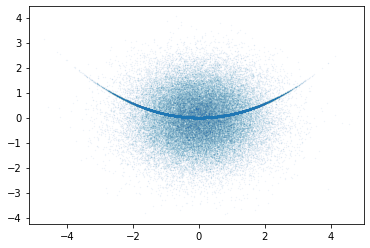

In [144]:
plt.scatter(valid_data[:,0],valid_data[:,1],s=0.1,alpha=0.1)

In [8]:
# https://arxiv.org/pdf/1611.00712.pdf

def build_and_compile_annealing_vae(encoder_conv_layers = [256,256,256,256],
                                    dense_size = 256,
                                    decoder = [512,256,256,256],
                                    verbose=0,dropout=0,
                                    latent_dim = 128,
                                    optimizer=keras.optimizers.Adam(),
                                    num_particles_out = 50,
                                    sinkhorn_reg = 0.01,
                                    numItermax = 20,
                                    stopThr=1e-3,
                                    adaptive_min = 0.01):
    
    temp = 0.3
    EPSILON = 1e-6
    #renorm_clipping={'rmax':3., 'rmin':1./3, 'dmax':5.}
    renorm_clipping = None
    momentum = 0.999
    
    def sampling_gauss(args):
        """Reparameterization trick by sampling fr an isotropic unit Gaussian.

        # Arguments
            args (tensor): mean and log of variance of Q(z|X)

        # Returns
            z (tensor): sampled latent vector
        """

        z_mean, z_log_var = args
        batch = K.shape(z_mean)[0]
        dim = K.int_shape(z_mean)[1]
        # by default, random_normal has mean=0 and std=1.0
        epsilon = K.random_normal(shape=(batch, dim))
        return z_mean + K.exp(0.5 * z_log_var) * epsilon
    
    def sampling_bern(theta):

        batch = K.shape(theta)[0]
        dim = K.int_shape(theta)[1]
        # by default, random_normal has mean=0 and std=1.0
        epsilon = K.random_uniform(shape=(batch, dim),maxval=1-EPSILON,minval=EPSILON)
        #return (K.log(epsilon) - K.log(1-epsilon) + K.log(theta+EPSILON) - K.log(1-theta+EPSILON))/temp
        return (K.log(epsilon) - K.log(1-epsilon) + K.log(theta+EPSILON))/temp
    
    num_particles = 700

    cat_dim = 2
    
    #Encoder
    inputs = tf.keras.Input(shape=(num_particles,3,), name='inputs')
    beta_input = tf.keras.Input(shape=(1,), name='beta_input')
    alpha_input = tf.keras.Input(shape=(1,), name='alpha_input')
#     layer = inputs
    #layer = tf.keras.layers.Concatenate()([inputs,beta_input,alpha_input])
    #layer = Lambda(lambda x: x[:,:real_dim])(layer)

    layer = inputs

    for layer_size in encoder_conv_layers:
        layer = Conv1D(layer_size,1,bias_initializer='glorot_uniform')(layer)
#         layer = BatchNormalization(renorm=True,
#                                      renorm_clipping=renorm_clipping,
#                                      momentum = momentum,
#                                      renorm_momentum=momentum)(layer)
        layer = keras.layers.ReLU()(layer)
        if dropout > 0:
            layer = keras.layers.Dropout(dropout)(layer)
    
    # Sum layer
    layer = tf.keras.backend.sum(layer,axis=0)

    # Dense layers 1
    layer = Dense(dense_size)(layer)
    layer = keras.layers.ReLU()(layer)
    layer = Dense(dense_size)(layer)
    layer = keras.layers.ReLU()(layer)

    # Cat latent
    alpha_bern = Dense(cat_dim, name='alpha_bern')(layer)
#     alpha_bern = BatchNormalization(renorm=True,
#                                      renorm_clipping=renorm_clipping,
#                                      momentum = 0.999,
#                                      renorm_momentum=0.999)(alpha_bern)
    alpha_bern = keras.layers.ELU()(alpha_bern)
    alpha_bern = keras.layers.Lambda(lambda x: x + 1)(alpha_bern)
#     alpha_bern = Activation('sigmoid')(alpha_bern)


    z_bern = Lambda(sampling_bern, output_shape=(cat_dim,), name='z_bern')(alpha_bern)
    z_bern_sigmoid = Activation('sigmoid')(z_bern)
    
    layer = tf.keras.layers.Concatenate()([layer,z_bern_sigmoid])

    # Dense layers 2
    layer = Dense(dense_size)(layer)
    layer = keras.layers.ReLU()(layer)
    layer = Dense(dense_size)(layer)
    layer = keras.layers.ReLU()(layer)
      
    z_mean = Dense(latent_dim, name='z_mean')(layer)
    z_log_var = Dense(latent_dim, name='z_log_var')(layer)
    z = Lambda(sampling_gauss, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])

    encoder = Model([inputs,beta_input,alpha_input], [z_mean, z_log_var, z, alpha_bern, z_bern_sigmoid], name='encoder')
    if verbose:
        encoder.summary()
    #plot_model(encoder, to_file='CNN-VAE_encoder.png', show_shapes=True)

    # Decoder
    latent_inputs_gauss = Input(shape=(latent_dim,), name='z_sampling')
    latent_inputs_bern = Input(shape=(cat_dim,), name='z_sampling_bern')
    layer = tf.keras.layers.Concatenate()([latent_inputs_gauss,latent_inputs_bern])
    #layer = latent_inputs
    
    for i, layer_size in enumerate(decoder):
        layer = Dense(layer_size,bias_initializer='glorot_uniform')(layer)
#         layer = BatchNormalization(renorm=True,
#                                      renorm_clipping=renorm_clipping,
#                                      momentum = momentum,
#                                      renorm_momentum=momentum)(layer)
        layer = keras.layers.ReLU()(layer)
        if dropout > 0:
            layer = keras.layers.Dropout(dropout)(layer)
            
    layer = Dense(num_particles_out*3)(layer)
    decoded = Reshape((-1,num_particles_out,3))(layer)

    decoder = Model([latent_inputs_gauss,latent_inputs_bern], decoded, name='decoder')
    if verbose:
        decoder.summary()
    #plot_model(decoder, to_file='CNN-VAE_decoder.png', show_shapes=True)


    outputs = decoder([encoder([inputs,beta_input,alpha_input])[2], encoder([inputs,beta_input,alpha_input])[4]])
    vae = Model([inputs,beta_input,alpha_input], outputs, name='CNN-VAE')

    def myfunc(alpha, x,temp=temp):
        #return (temp*alpha*K.pow(x,-temp-1)*K.pow(1-x,-temp-1))/K.square(alpha*K.pow(x,-temp) + K.pow(1-x,-temp))
        return K.log(temp) - temp*x + K.log(alpha + EPSILON) - 2*K.log(1+alpha*K.exp(-temp*x ))
        #return K.log(alpha + EPSILON) - 2*K.log(1+alpha*K.exp(-temp*x ))

    def beta_vae_loss(beta, alpha):
        def vae_loss(x, x_decoded_mean):
            #xent_loss = K.sqrt(K.sum(K.square(x - x_decoded_mean),axis=-1))
            xent_loss = K.sum(K.square(x - x_decoded_mean),axis=-1)
            p_alpha = alpha_bern/(1+alpha_bern)
            #p_alpha = alpha_bern
            kl_loss_bern = K.sum(p_alpha*K.log(p_alpha/0.5+EPSILON) + (1-p_alpha)*K.log((1-p_alpha)/0.5+EPSILON),axis=-1)
            kl_loss = - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
            return K.mean(xent_loss/beta**2 + kl_loss + alpha* kl_loss_bern)
        return vae_loss

    

    @tf.custom_gradient
    def return_loss(pt_out, x_out, pt_in, x_in):

        epsilon = np.float64(1e-10)
        ground_distance = ground_distance_tf_nograd(x_in,x_out)

        match = sinkhorn_knopp_tf_64(pt_in, pt_out, tf.stop_gradient(ground_distance), sinkhorn_reg, numItermax=numItermax, stopThr=stopThr, adaptive_min=adaptive_min)        
        recon_loss = tf.linalg.trace(tf.matmul(tf.stop_gradient(tf.cast(match,tf.float32)),ground_distance,transpose_b=True))
        
        def grad(dL):
            aones = tf.fill(tf.shape(pt_in),np.float64(1.))
            bones = tf.fill(tf.shape(pt_out),np.float64(1.))

            Mnew = tf.cast(tf.transpose(ground_distance,perm=[0,2,1]),tf.float64)

            T = tf.cast(tf.transpose(match,perm=[0,2,1]),tf.float64)
            Ttilde = T[:,:,:-1]

            L = T * Mnew
            Ltilde = L[:,:,:-1]

            D1 = tf.matrix_diag(tf.reduce_sum(T,axis=-1))
            D2 = tf.matrix_diag(1/(tf.reduce_sum(Ttilde,axis=-2) + np.float64(1e-100))) # Add epsilon to ensure invertibility

            H = D1 - tf.matmul(tf.matmul(Ttilde,D2),Ttilde,transpose_b=True) + epsilon* tf.eye(num_rows = tf.shape(bones)[-1],batch_shape = [tf.shape(bones)[0]],dtype=tf.float64) # Add small diagonal piece to make sure H is invertible in edge cases.

            f = - tf.reduce_sum(L,axis=-1) + tf.squeeze(tf.matmul(tf.matmul(Ttilde,D2),tf.expand_dims(tf.reduce_sum(Ltilde,axis=-2),-1)),axis=-1)
            g = tf.squeeze(tf.matmul(tf.linalg.inv(H),tf.expand_dims(f,-1)),axis=-1)

            grad_pT = g - bones*tf.expand_dims(tf.reduce_sum(g,axis=-1),-1)/tf.cast(tf.shape(bones)[1],tf.float64)
            
            grad_x_out = tf.gradients(recon_loss,x_out)[0]
            
            return [-tf.expand_dims(dL,-1) * tf.cast(grad_pT,tf.float32),
                    tf.expand_dims(tf.expand_dims(dL,-1),-1)*tf.cast(grad_x_out,tf.float32)]

        return recon_loss, grad

    def recon_loss(x, x_decoded_mean):
        pt_out = x_decoded_mean[:,:,0]
        x_out = x_decoded_mean[:,:,1:]
        pt_in = x[:,:,0]
        x_in = x[:,:,1:]
        return tf.reduce_mean(return_loss(pt_out, x_out, pt_in, x_in),axis=0)

    def kl_loss(beta):
        def get_kl_loss(x, x_decoded_mean):
            kl_loss = -0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
            return K.mean( kl_loss)
        return get_kl_loss
    
    def kl_loss_bern(beta):
        def get_kl_loss_bern(x, x_decoded_mean):
            p_alpha = alpha_bern/(1+alpha_bern)
            #p_alpha = alpha_bern
            kl_loss = K.sum(p_alpha*K.log(p_alpha/0.5+EPSILON) + (1-p_alpha)*K.log((1-p_alpha)/0.5+EPSILON),axis=-1)
            return K.mean( kl_loss)
        return get_kl_loss_bern
    
    vae.compile(loss=beta_vae_loss(beta_input, alpha_input),
                optimizer=optimizer,
                metrics = [recon_loss,kl_loss(beta_input), kl_loss_bern(beta_input)]
               )
    
    vae.summary()
    
    return vae, encoder, decoder

experiment_name = 'banana_bern_test'
train_output_dir = create_dir(osp.join(output_dir, experiment_name))

save_period = 2
modelcheckpoint = keras.callbacks.ModelCheckpoint(train_output_dir + '/model_{epoch:02d}.hdf5', period = save_period)
reduceLR = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=1, verbose=1, mode='auto', min_delta=0.0001, cooldown=0, min_lr=0)
earlystop = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=2, verbose=0, mode='auto', baseline=None, restore_best_weights=False)

callbacks = [modelcheckpoint,reduceLR,earlystop]

class encoder_class():
    def __init__(self,encoder):
        self.encoder = encoder
        
    def predict(self, data):
        return self.encoder.predict([data,np.ones(len(data)),np.ones(len(data))])

In [6]:
# https://arxiv.org/pdf/1611.00712.pdf

encoder_conv_layers = [256,256,256,256]
dense_size = 256
decoder = [512,256,256,256]
verbose=0
dropout=0
latent_dim = 128
optimizer=keras.optimizers.Adam()
num_particles_out = 50
sinkhorn_reg = 0.01
numItermax = 20
stopThr=1e-3
adaptive_min = 0.01

temp = 0.3
EPSILON = 1e-6
#renorm_clipping={'rmax':3., 'rmin':1./3, 'dmax':5.}
renorm_clipping = None
momentum = 0.999

def sampling_gauss(args):
    """Reparameterization trick by sampling fr an isotropic unit Gaussian.

    # Arguments
        args (tensor): mean and log of variance of Q(z|X)

    # Returns
        z (tensor): sampled latent vector
    """

    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    # by default, random_normal has mean=0 and std=1.0
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

def sampling_bern(theta):

    batch = K.shape(theta)[0]
    dim = K.int_shape(theta)[1]
    # by default, random_normal has mean=0 and std=1.0
    epsilon = K.random_uniform(shape=(batch, dim),maxval=1-EPSILON,minval=EPSILON)
    #return (K.log(epsilon) - K.log(1-epsilon) + K.log(theta+EPSILON) - K.log(1-theta+EPSILON))/temp
    return (K.log(epsilon) - K.log(1-epsilon) + K.log(theta+EPSILON))/temp

num_particles = 700

cat_dim = 2

#Encoder
inputs = tf.keras.Input(shape=(num_particles,3,), name='inputs')
beta_input = tf.keras.Input(shape=(1,), name='beta_input')
alpha_input = tf.keras.Input(shape=(1,), name='alpha_input')
#     layer = inputs
#layer = tf.keras.layers.Concatenate()([inputs,beta_input,alpha_input])
#layer = Lambda(lambda x: x[:,:real_dim])(layer)

layer = inputs

for layer_size in encoder_conv_layers:
    layer = Conv1D(layer_size,1,bias_initializer='glorot_uniform')(layer)
#         layer = BatchNormalization(renorm=True,
#                                      renorm_clipping=renorm_clipping,
#                                      momentum = momentum,
#                                      renorm_momentum=momentum)(layer)
    layer = keras.layers.ReLU()(layer)
    if dropout > 0:
        layer = keras.layers.Dropout(dropout)(layer)

# Sum layer
layer = tf.keras.backend.sum(layer,axis=1)

# Dense layers 1
layer = Dense(dense_size)(layer)
layer = keras.layers.ReLU()(layer)
layer = Dense(dense_size)(layer)
layer = keras.layers.ReLU()(layer)

# Cat latent
alpha_bern = Dense(cat_dim, name='alpha_bern')(layer)
#     alpha_bern = BatchNormalization(renorm=True,
#                                      renorm_clipping=renorm_clipping,
#                                      momentum = 0.999,
#                                      renorm_momentum=0.999)(alpha_bern)
alpha_bern = keras.layers.ELU()(alpha_bern)
alpha_bern = keras.layers.Lambda(lambda x: x + 1)(alpha_bern)
#     alpha_bern = Activation('sigmoid')(alpha_bern)


z_bern = Lambda(sampling_bern, output_shape=(cat_dim,), name='z_bern')(alpha_bern)
z_bern_sigmoid = Activation('sigmoid')(z_bern)

layer = tf.keras.layers.Concatenate()([layer,z_bern_sigmoid])

# Dense layers 2
layer = Dense(dense_size)(layer)
layer = keras.layers.ReLU()(layer)
layer = Dense(dense_size)(layer)
layer = keras.layers.ReLU()(layer)
    
z_mean = Dense(latent_dim, name='z_mean')(layer)
z_log_var = Dense(latent_dim, name='z_log_var')(layer)
z = Lambda(sampling_gauss, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])

encoder = Model([inputs,beta_input,alpha_input], [z_mean, z_log_var, z, alpha_bern, z_bern_sigmoid], name='encoder')
if verbose:
    encoder.summary()
#plot_model(encoder, to_file='CNN-VAE_encoder.png', show_shapes=True)

# Decoder
latent_inputs_gauss = Input(shape=(latent_dim,), name='z_sampling')
latent_inputs_bern = Input(shape=(cat_dim,), name='z_sampling_bern')
layer = tf.keras.layers.Concatenate()([latent_inputs_gauss,latent_inputs_bern])
#layer = latent_inputs

for i, layer_size in enumerate(decoder):
    layer = Dense(layer_size,bias_initializer='glorot_uniform')(layer)
#         layer = BatchNormalization(renorm=True,
#                                      renorm_clipping=renorm_clipping,
#                                      momentum = momentum,
#                                      renorm_momentum=momentum)(layer)
    layer = keras.layers.ReLU()(layer)
    if dropout > 0:
        layer = keras.layers.Dropout(dropout)(layer)
        
layer = Dense(num_particles_out*3)(layer)
mylayer = layer
decoded = Reshape((num_particles_out,3))(layer)

decoder = Model([latent_inputs_gauss,latent_inputs_bern], decoded, name='decoder')
if verbose:
    decoder.summary()
#plot_model(decoder, to_file='CNN-VAE_decoder.png', show_shapes=True)


outputs = decoder([encoder([inputs,beta_input,alpha_input])[2], encoder([inputs,beta_input,alpha_input])[4]])
vae = Model([inputs,beta_input,alpha_input], outputs, name='CNN-VAE')

def myfunc(alpha, x,temp=temp):
    #return (temp*alpha*K.pow(x,-temp-1)*K.pow(1-x,-temp-1))/K.square(alpha*K.pow(x,-temp) + K.pow(1-x,-temp))
    return K.log(temp) - temp*x + K.log(alpha + EPSILON) - 2*K.log(1+alpha*K.exp(-temp*x ))
    #return K.log(alpha + EPSILON) - 2*K.log(1+alpha*K.exp(-temp*x ))

def beta_vae_loss(beta, alpha):
    def vae_loss(x, x_decoded_mean):
        #xent_loss = K.sqrt(K.sum(K.square(x - x_decoded_mean),axis=-1))
        xent_loss = K.sum(K.square(x - x_decoded_mean),axis=-1)
        p_alpha = alpha_bern/(1+alpha_bern)
        #p_alpha = alpha_bern
        kl_loss_bern = K.sum(p_alpha*K.log(p_alpha/0.5+EPSILON) + (1-p_alpha)*K.log((1-p_alpha)/0.5+EPSILON),axis=-1)
        kl_loss = - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
        return K.mean(xent_loss/beta**2 + kl_loss + alpha* kl_loss_bern)
    return vae_loss



@tf.custom_gradient
def return_loss(pt_out, x_out, pt_in, x_in):

    epsilon = np.float64(1e-10)
    ground_distance = ground_distance_tf_nograd(x_in,x_out)

    match = sinkhorn_knopp_tf_64(pt_in, pt_out, tf.stop_gradient(ground_distance), sinkhorn_reg, numItermax=numItermax, stopThr=stopThr, adaptive_min=adaptive_min)        
    recon_loss = tf.linalg.trace(tf.matmul(tf.stop_gradient(tf.cast(match,tf.float32)),ground_distance,transpose_b=True))
    
    def grad(dL, variables=None):
        aones = tf.fill(tf.shape(pt_in),np.float64(1.))
        bones = tf.fill(tf.shape(pt_out),np.float64(1.))

        Mnew = tf.cast(tf.transpose(ground_distance,perm=[0,2,1]),tf.float64)

        T = tf.cast(tf.transpose(match,perm=[0,2,1]),tf.float64)
        Ttilde = T[:,:,:-1]

        L = T * Mnew
        Ltilde = L[:,:,:-1]

        D1 = tf.matrix_diag(tf.reduce_sum(T,axis=-1))
        D2 = tf.matrix_diag(1/(tf.reduce_sum(Ttilde,axis=-2) + np.float64(1e-100))) # Add epsilon to ensure invertibility

        H = D1 - tf.matmul(tf.matmul(Ttilde,D2),Ttilde,transpose_b=True) + epsilon* tf.eye(num_rows = tf.shape(bones)[-1],batch_shape = [tf.shape(bones)[0]],dtype=tf.float64) # Add small diagonal piece to make sure H is invertible in edge cases.

        f = - tf.reduce_sum(L,axis=-1) + tf.squeeze(tf.matmul(tf.matmul(Ttilde,D2),tf.expand_dims(tf.reduce_sum(Ltilde,axis=-2),-1)),axis=-1)
        g = tf.squeeze(tf.matmul(tf.linalg.inv(H),tf.expand_dims(f,-1)),axis=-1)

        grad_pT = g - bones*tf.expand_dims(tf.reduce_sum(g,axis=-1),-1)/tf.cast(tf.shape(bones)[1],tf.float64)
        
        grad_x_out = tf.gradients(recon_loss,x_out)[0]
        
        return [-tf.expand_dims(dL,-1) * tf.cast(grad_pT,tf.float32),
                tf.expand_dims(tf.expand_dims(dL,-1),-1)*tf.cast(grad_x_out,tf.float32)]

    return recon_loss, grad

def recon_loss(x, x_decoded_mean):
    pt_out = x_decoded_mean[:,:,0]
    x_out = x_decoded_mean[:,:,1:]
    pt_in = x[:,:,0]
    x_in = x[:,:,1:]
    return tf.reduce_mean(return_loss(pt_out, x_out, pt_in, x_in),axis=0)

def kl_loss(beta):
    def get_kl_loss(x, x_decoded_mean):
        kl_loss = -0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
        return K.mean( kl_loss)
    return get_kl_loss

def kl_loss_bern(beta):
    def get_kl_loss_bern(x, x_decoded_mean):
        p_alpha = alpha_bern/(1+alpha_bern)
        #p_alpha = alpha_bern
        kl_loss = K.sum(p_alpha*K.log(p_alpha/0.5+EPSILON) + (1-p_alpha)*K.log((1-p_alpha)/0.5+EPSILON),axis=-1)
        return K.mean( kl_loss)
    return get_kl_loss_bern

vae.compile(loss=beta_vae_loss(beta_input, alpha_input),
            optimizer=optimizer,
            metrics = [recon_loss,kl_loss(beta_input), kl_loss_bern(beta_input)]
            )

vae.summary()

return vae, encoder, decoder

experiment_name = 'banana_bern_test'
train_output_dir = create_dir(osp.join(output_dir, experiment_name))

save_period = 2
modelcheckpoint = keras.callbacks.ModelCheckpoint(train_output_dir + '/model_{epoch:02d}.hdf5', period = save_period)
reduceLR = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=1, verbose=1, mode='auto', min_delta=0.0001, cooldown=0, min_lr=0)
earlystop = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=2, verbose=0, mode='auto', baseline=None, restore_best_weights=False)

callbacks = [modelcheckpoint,reduceLR,earlystop]

class encoder_class():
    def __init__(self,encoder):
        self.encoder = encoder
        
    def predict(self, data):
        return self.encoder.predict([data,np.ones(len(data)),np.ones(len(data))])

Note that input tensors are instantiated via `tensor = tf.keras.Input(shape)`.
The tensor that caused the issue was: beta_input_2:0
Note that input tensors are instantiated via `tensor = tf.keras.Input(shape)`.
The tensor that caused the issue was: alpha_input_2:0
Model: "CNN-VAE"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inputs (InputLayer)             [(None, 700, 3)]     0                                            
__________________________________________________________________________________________________
beta_input (InputLayer)         [(None, 1)]          0                                            
__________________________________________________________________________________________________
alpha_input (InputLayer)        [(None, 1)]          0                                            
_________________________

SyntaxError: 'return' outside function (<ipython-input-6-69b36d23ad69>, line 225)

In [16]:
tf.linalg.tr

<tf.Tensor 'inputs_2:0' shape=(None, 100, 700, 3) dtype=float32>

In [20]:
tf.shape(pointsa)[-2]

<tf.Tensor 'strided_slice_2:0' shape=() dtype=int32>

In [6]:
pointsb = inputs[:,:,1:]
pointsa = outputs[:,:,1:]

a_dim = pointsa.shape[-2]
b_dim = pointsb.shape[-2]

In [7]:
amat = tf.tile(tf.expand_dims(pointsa,2),[1,1,b_dim,1])
bmat = tf.tile(tf.expand_dims(pointsb,1),[1,a_dim,1,1])

In [9]:
bmat

<tf.Tensor 'Tile_1:0' shape=(None, 50, 700, 2) dtype=float32>

In [10]:
diffmat = bmat - amat

In [11]:
diffmat

<tf.Tensor 'sub:0' shape=(None, 50, 700, 2) dtype=float32>

In [9]:
experiment_name = '2D_banana'
vae, encoder, decoder = build_and_compile_annealing_vae(optimizer=keras.optimizers.Adam(lr=0.001,clipnorm=0.1))



Note that input tensors are instantiated via `tensor = tf.keras.Input(shape)`.
The tensor that caused the issue was: beta_input_1:0
Note that input tensors are instantiated via `tensor = tf.keras.Input(shape)`.
The tensor that caused the issue was: alpha_input_1:0


ValueError: Shape must be rank 5 but is rank 4 for 'metrics_2/recon_loss/Tile' (op: 'Tile') with input shapes: [?,?,1,?,?], [4].

In [15]:
Reshape

tensorflow.python.keras.layers.core.Reshape

In [71]:
# You are welcome to load a pretrained model
vae.load_weights('mymodel_weights.h5')

ValueError: Shapes (512, 256) and (512,) are incompatible

In [108]:
reduceLR = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, verbose=1, mode='auto', min_delta=1e-4, cooldown=0, min_lr=0)
earlystop = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=1e-4, patience=5, verbose=0, mode='auto', baseline=None, restore_best_weights=False)
callbacks = [#modelcheckpoint,
             reduceLR,earlystop]

beta = 1e-1
alpha = 1.0

K.set_value(vae.optimizer.lr,1e-5)
epochs = 1000
history = vae.fit(x=[train_data,np.ones(len(train_data))*beta,np.ones(len(train_data))*alpha], y=train_data, batch_size=100,
                epochs=epochs,verbose=1,#initial_epoch=history.epoch[-1],
                validation_data = ([valid_data,np.ones(len(valid_data))*beta,np.ones(len(valid_data))*alpha],valid_data),
                callbacks = callbacks
              )

# tf.saved_model.save(vae, train_output_dir + '/mymodel.hdf5')

Train on 1000000 samples, validate on 100000 samples
Epoch 1/1000
1000000/1000000 [==============================] - 47s 47us/sample - loss: 5.4467 - recon_loss: 0.0118 - get_kl_loss: 3.9512 - get_kl_loss_bern: 0.3162 - val_loss: 5.4089 - val_recon_loss: 0.0109 - val_get_kl_loss: 3.9862 - val_get_kl_loss_bern: 0.3280
Epoch 2/1000
1000000/1000000 [==============================] - 47s 47us/sample - loss: 5.3745 - recon_loss: 0.0104 - get_kl_loss: 4.0093 - get_kl_loss_bern: 0.3299 - val_loss: 5.3612 - val_recon_loss: 0.0103 - val_get_kl_loss: 3.9984 - val_get_kl_loss_bern: 0.3310
Epoch 3/1000
1000000/1000000 [==============================] - 46s 46us/sample - loss: 5.3662 - recon_loss: 0.0102 - get_kl_loss: 4.0106 - get_kl_loss_bern: 0.3314 - val_loss: 5.3478 - val_recon_loss: 0.0103 - val_get_kl_loss: 3.9904 - val_get_kl_loss_bern: 0.3312
Epoch 4/1000
1000000/1000000 [==============================] - 47s 47us/sample - loss: 5.3595 - recon_loss: 0.0101 - get_kl_loss: 4.0123 - get_kl_lo

In [109]:
vae.save_weights('mymodel_weights_2.h5')

Latent space encoding for beta = 0.18 :


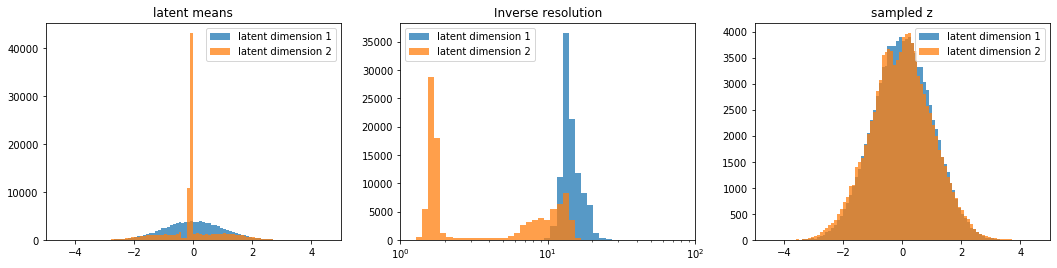

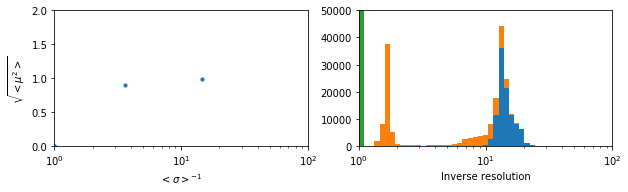

[0.35532367 0.501202  ]
[0.96436054 0.02042921]
categories =  [1, 1]


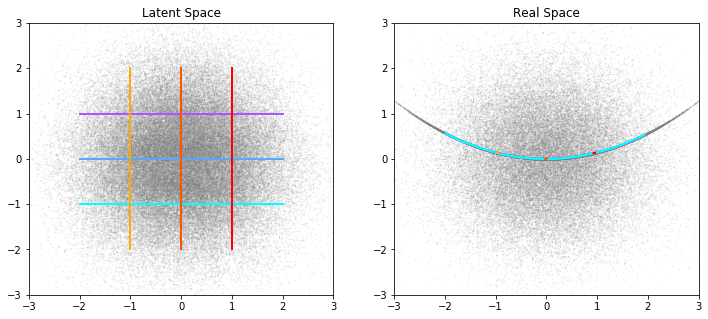

categories =  [1, 0]


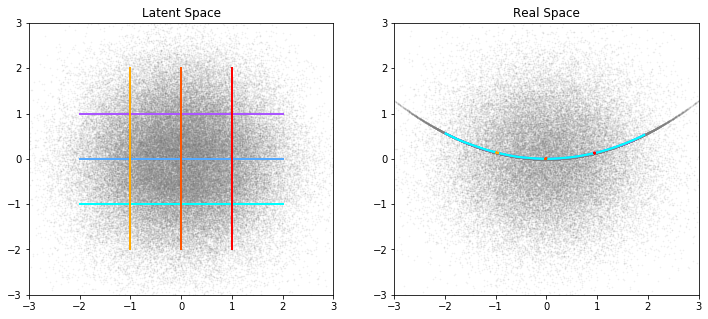

categories =  [0, 0]


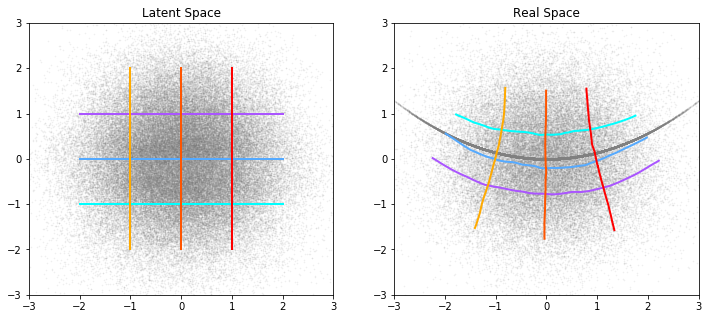

categories =  [0, 1]


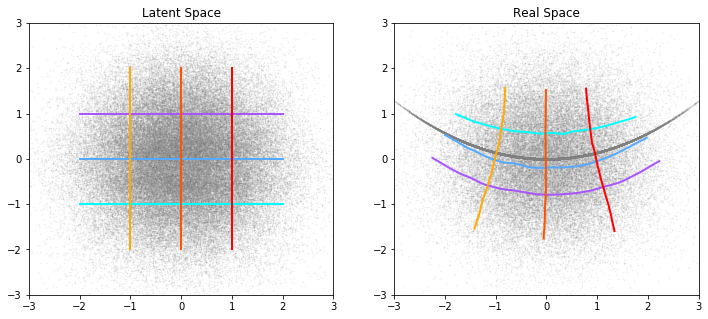

In [143]:
vae.load_weights('mymodel_weights_2.h5')
beta = 0.18

print("Latent space encoding for beta =",beta,":")
myencoder = encoder_class(encoder)
    
plot_latent_space(myencoder,valid_data,xrange = [1,1e2])
plot_latent_space_2(myencoder,valid_data,xrange = [1,1e2])

myencoder = encoder_class(encoder)
z_mu, z_logvar, z, theta, sig = myencoder.predict(valid_data)
print(np.mean(sig,axis=-2))
print(np.std(theta,axis=-2))

for cats in [[1,1],[1,0],[0,0],[0,1]]:
    print("categories = ", cats)
    plot_latent_map(myencoder, decoder, valid_data,
                    cats,
                        scales = np.array([[-2,2],[-2,2]]),
                        values = np.array([[1,0,-1],[1,0,-1]]),
                        latent_plotrange = [-3,3])

# print("categories = ", cats)

# plot_latent_map(myencoder, decoder, valid_data,
#                 [1,0],
#                     scales = np.array([[-2,2],[-2,2]]),
#                     values = np.array([[-1,0,1],[-1,0,1]]),
#                     latent_plotrange = [-3,3])

# print("categories = ", cats)

# plot_latent_map(myencoder, decoder, valid_data,
#                 [0,1],
#                     scales = np.array([[-2,2],[-2,2]]),
#                     values = np.array([[-1,0,1],[-1,0,1]]),
#                     latent_plotrange = [-3,3])

# print("categories = ", cats)

# plot_latent_map(myencoder, decoder, valid_data,
#                 [0,0],
#                     scales = np.array([[-2,2],[-2,2]]),
#                     values = np.array([[-1,0,1],[-1,0,1]]),
#                     latent_plotrange = [-3,3])

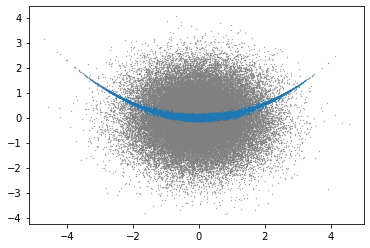

In [121]:
banana_ids = np.where(sig[:,0] > 0.5)
not_banana_ids = np.where(sig[:,0] <= 0.5)
banana = valid_data[banana_ids]
not_banana = valid_data[not_banana_ids]
plt.scatter(not_banana[:,0],not_banana[:,1],s=0.1,color='gray')
plt.scatter(banana[:,0],banana[:,1],s=0.1)

Latent space encoding for beta = 0.18 :


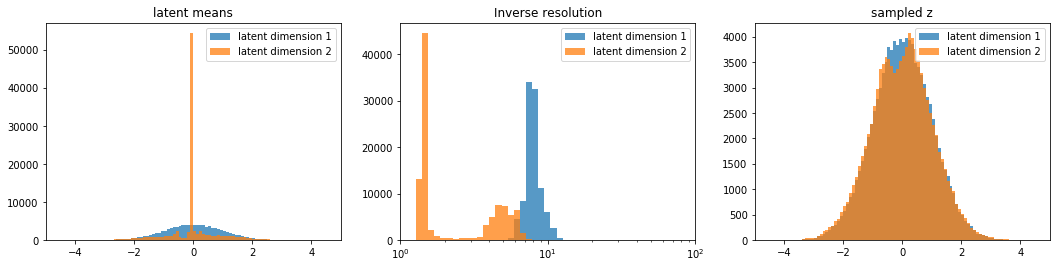

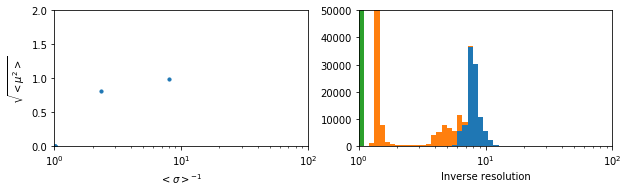

[0.38904503 0.50221467]
[0.9156216  0.01675496]


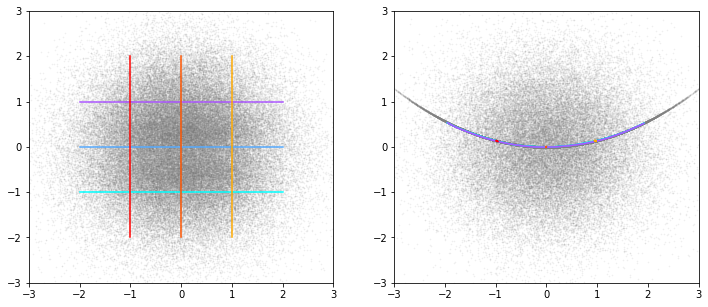

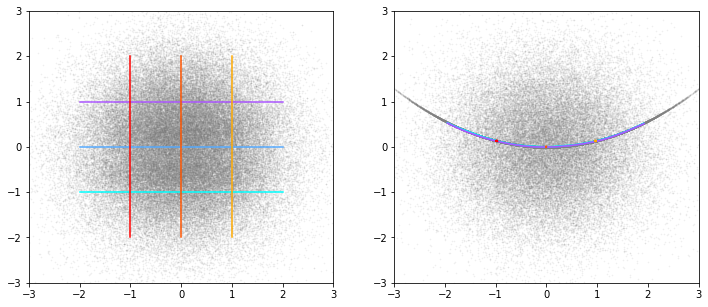

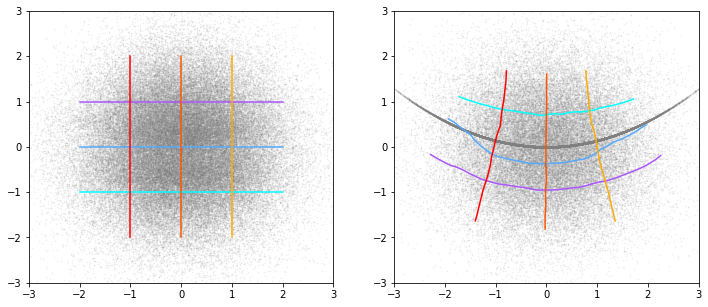

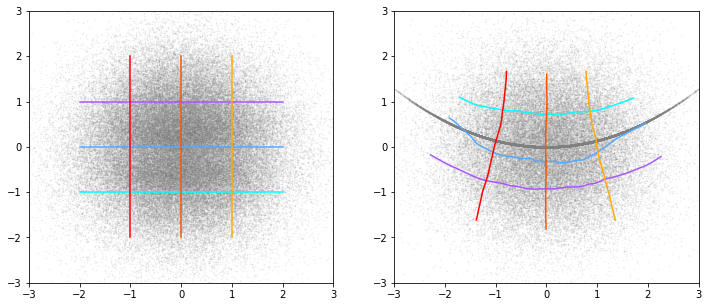

In [107]:
vae.load_weights('mymodel_weights_1.h5')
beta = 0.18

print("Latent space encoding for beta =",beta,":")
myencoder = encoder_class(encoder)
    
plot_latent_space(myencoder,valid_data,xrange = [1,1e2])
plot_latent_space_2(myencoder,valid_data,xrange = [1,1e2])

myencoder = encoder_class(encoder)
z_mu, z_logvar, z, theta, sig = myencoder.predict(valid_data)
print(np.mean(sig,axis=-2))
print(np.std(theta,axis=-2))

plot_latent_map(myencoder, decoder, valid_data,
                [1,1],
                    scales = np.array([[-2,2],[-2,2]]),
                    values = np.array([[-1,0,1],[-1,0,1]]),
                    latent_plotrange = [-3,3])

plot_latent_map(myencoder, decoder, valid_data,
                [1,0],
                    scales = np.array([[-2,2],[-2,2]]),
                    values = np.array([[-1,0,1],[-1,0,1]]),
                    latent_plotrange = [-3,3])

plot_latent_map(myencoder, decoder, valid_data,
                [0,1],
                    scales = np.array([[-2,2],[-2,2]]),
                    values = np.array([[-1,0,1],[-1,0,1]]),
                    latent_plotrange = [-3,3])

plot_latent_map(myencoder, decoder, valid_data,
                [0,0],
                    scales = np.array([[-2,2],[-2,2]]),
                    values = np.array([[-1,0,1],[-1,0,1]]),
                    latent_plotrange = [-3,3])

Latent space encoding for beta = 0.3 :


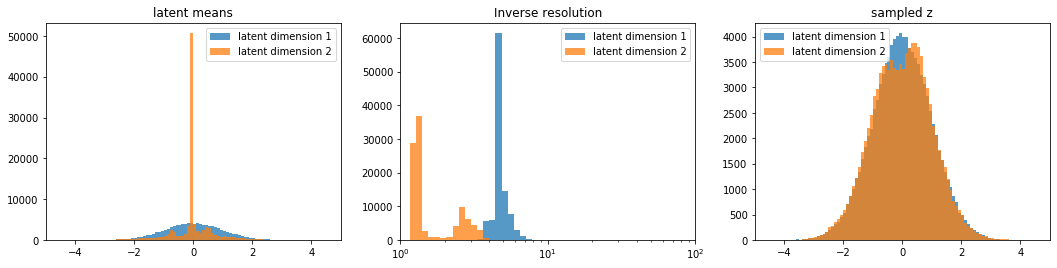

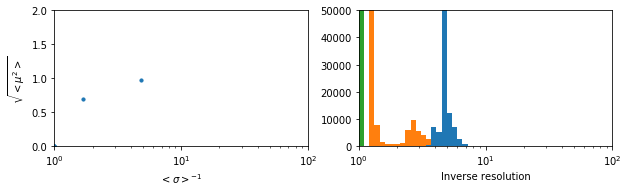

[0.4239141 0.5006592]
[0.8254102  0.02957428]


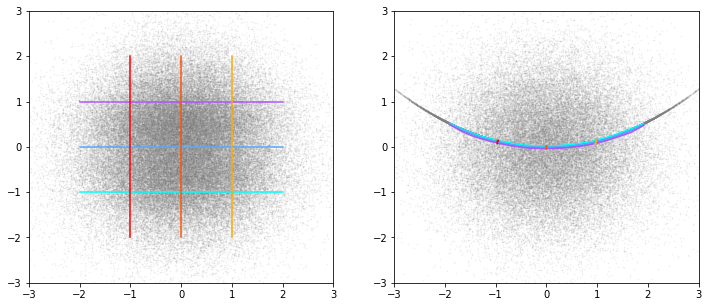

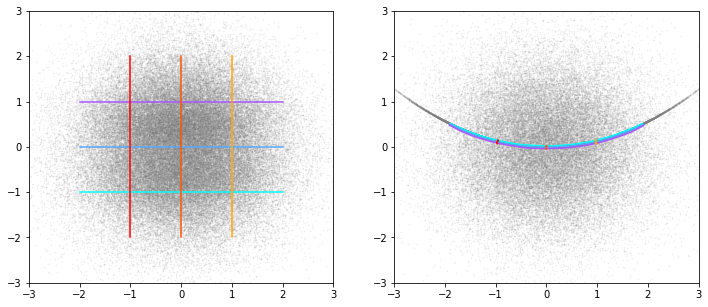

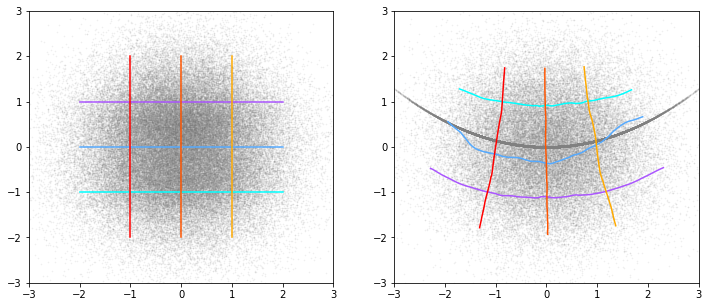

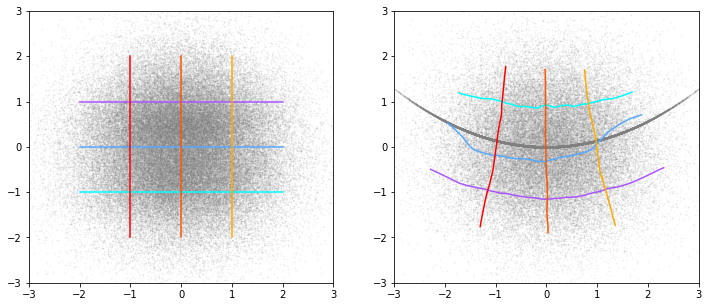

In [102]:
vae.load_weights('mymodel_weights_0.h5')
beta = 0.3

print("Latent space encoding for beta =",beta,":")
myencoder = encoder_class(encoder)
    
plot_latent_space(myencoder,valid_data,xrange = [1,1e2])
plot_latent_space_2(myencoder,valid_data,xrange = [1,1e2])

myencoder = encoder_class(encoder)
z_mu, z_logvar, z, theta, sig = myencoder.predict(valid_data)
print(np.mean(sig,axis=-2))
print(np.std(theta,axis=-2))

plot_latent_map(myencoder, decoder, valid_data,
                [1,1],
                    scales = np.array([[-2,2],[-2,2]]),
                    values = np.array([[-1,0,1],[-1,0,1]]),
                    latent_plotrange = [-3,3])

plot_latent_map(myencoder, decoder, valid_data,
                [1,0],
                    scales = np.array([[-2,2],[-2,2]]),
                    values = np.array([[-1,0,1],[-1,0,1]]),
                    latent_plotrange = [-3,3])

plot_latent_map(myencoder, decoder, valid_data,
                [0,1],
                    scales = np.array([[-2,2],[-2,2]]),
                    values = np.array([[-1,0,1],[-1,0,1]]),
                    latent_plotrange = [-3,3])

plot_latent_map(myencoder, decoder, valid_data,
                [0,0],
                    scales = np.array([[-2,2],[-2,2]]),
                    values = np.array([[-1,0,1],[-1,0,1]]),
                    latent_plotrange = [-3,3])